In [1]:
%matplotlib inline
import scipy.sparse as sparse
import scipy.sparse.linalg as linalg
import matplotlib.pyplot as plt
import numpy as np
import sys
from mpl_toolkits.mplot3d import Axes3D

# Quantum dynamics

For this assignment we want to calculate the solution to the time-dependent Schrödinger equation so that we can evolve wave packets in time. We have done this using the Crank-Nicolson method for 1D and 2D, where we have simulated a gaussian wavepacket incident on a rectangular and triangular potential barrier (1D) as well as a gaussian wavefront incident on a double slit (2D). In this notebook we will first describe how we have found a solution to the SE using the Crank-Nicolson method for both 1D and 2D, followed by the plots and/or animations corresponding to our simulations on the potential barriers as described above.

## Crank-Nicolson method

## 1D Wavepacket through rectangular barrier


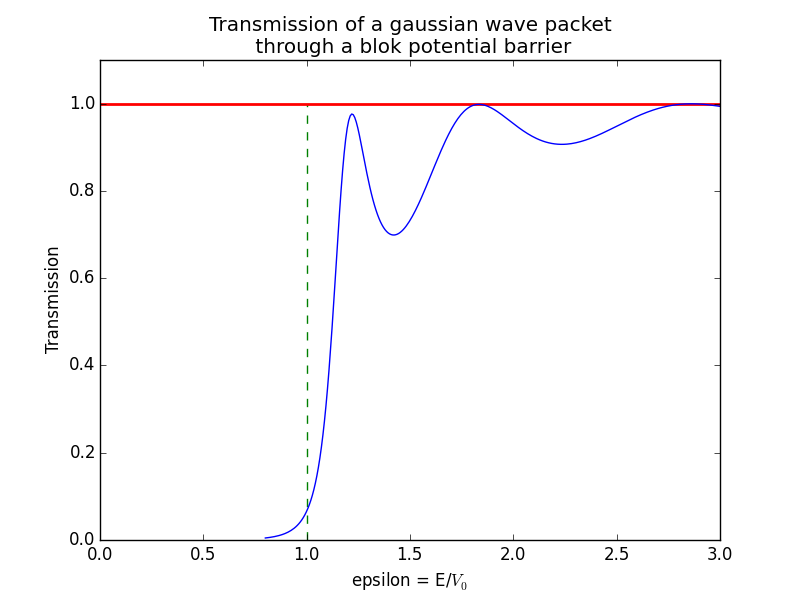

In [2]:
from IPython.display import Image
Image(filename='./media/blok_barrier.png')
Image(filename='./media/triangular_barrier.png')

## 2D Wavefront incident on a double slit

In [3]:
from IPython.display import HTML
HTML("""
<video width="600" height="480" controls>
  <source src="./media/animation.mp4" type="video/mp4">
</video>
""")

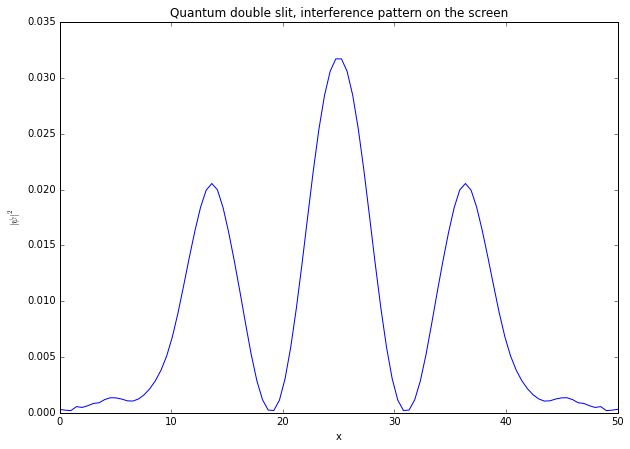

In [10]:
# Crank-Nicolson method QD time evolution simulation of a gaussian
# wavefront incident on a double slit
def main():

    ## simulation constants ##

    dt = .05            # time step
    dx = .5             # spatial grid distance
    L = 50.             # simulation space length
    k = 15.             # absolute value wave vector
    x0 = 0.25*L         # starting point wave front
    x1 = 0.25*L         # screen distance
    a = 0.6             # slit width
    d = 5               # slit spacing
    n = np.floor(L/dx)  # number of gridpoints along 1 dimension

    # initialize psi and the potential and calculate A and B for CN
    x, y = np.tile(np.linspace(0,L,n), n), np.repeat(np.linspace(0,L,n), n)
    psi = init_psi(x, x0, k, dx)
    v = double_slit_potential(x, y, L, a, d)
    A, B = calculate_AB(dx, dt, v, n)

    # find the interference pattern at the screen
    interference = run(psi, A, B, L, n, x1)

    # plot the
    plot_interference(np.linspace(0,L,n), interference)

###############
## functions ##
###############

# calculate the matrices for the Crank-Nicolson method
# A = Identity + constant*Hamiltonian
# B = Identity - constant*Hamiltonian
def calculate_AB(dx, dt, v, n):
    N = n**2

    # two constants to simplify the expressions
    c1 = 1.j * dt / (4. * dx**2)
    c2 = 1.j * dt / 2.

    temp = np.ones((1,n))
    temp[0,n-1] = 0.0
    temp = np.tile(temp, n)

    A = sparse.diags(1.+4.*c1+c2*v, 0) \
        - c1*sparse.eye(N,N,n) - c1*sparse.eye(N,N,-n) \
        - c1*sparse.diags(temp[0,0:(N-1)],-1) - c1*sparse.diags(temp[0,0:(N-1)],1)
    B = sparse.diags(1.-4.*c1-c2*v, 0) \
        + c1*sparse.eye(N,N,n) + c1*sparse.eye(N,N,-n) \
        + c1*sparse.diags(temp[0,0:(N-1)],-1) + c1*sparse.diags(temp[0,0:(N-1)],1)


    return A, B

# run the time evolution and return the transmission by solving the
# matrix equation A*psi(t+dt) = B*psi(t) using the bicgstab method.
def run(psi, A, B, L, n, x1):

    psiPlot = np.abs(psi.reshape(n,n)**2)
    interference = psiPlot[:,np.round(3.*n/4.)]
    for i in range(300):
        [psi, error] = linalg.bicgstab(A, B*psi,x0=psi)
        if error != 0: sys.exit("bicgstab did not converge")

        psiPlot = np.abs(psi.reshape(n,n)**2)
        interference += psiPlot[:,np.round((x1+0.5*L)*n/L)]

    return interference

# initialize the wave function
def init_psi(x, x0, k, dx):

    psi = np.exp(-0.1*((x-x0)**2)) * np.exp(1.j*k*x)  # gaussian front
    psi /= np.sqrt(sum(abs(psi)**2*dx**2))  # normalize the wave function

    return psi

# initialize a double slit potential barrier at
def double_slit_potential(x, y, L, a, d):

    v = 12.5*(np.abs(3*L/8 - x) < a)
    v2 = 1.0*(np.abs((L-d)/2 - y) > a)
    v3 = 1.0*(np.abs((L+d)/2 - y) > a)

    return v2 * v * v3

# plots the interference after the run
def plot_interference(x, interference):

    fig=plt.figure(figsize=(10, 7))
    plt.plot(x, interference, 'b')
    plt.title("Quantum double slit, interference pattern on the screen")
    plt.xlabel("x")
    plt.ylabel("$|\psi|^2$")
    plt.show()


##############
##   main   ##
##############
main()
